In [40]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from keras.layers import Input, Conv2D, UpSampling2D


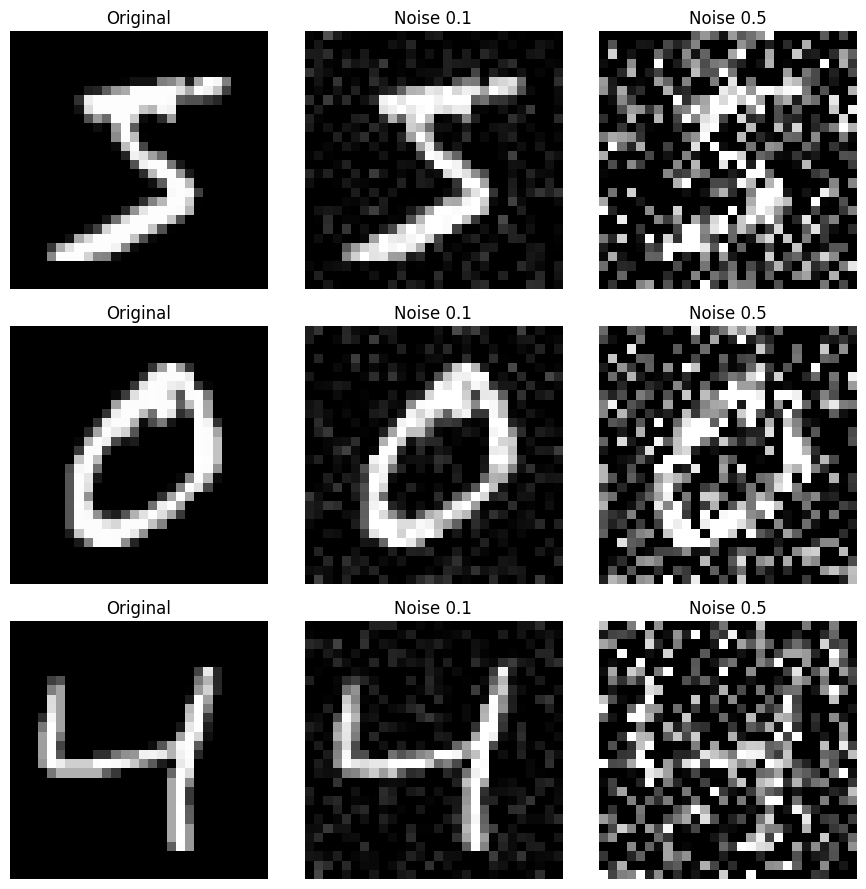

In [29]:
# Load and preprocess MNIST
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))
#Generate noisy versions
noise_factor_low = 0.1
noise_factor_high = 0.5
x_train_noisy_low = x_train + noise_factor_low * np.random.normal(loc=0.0, scale=1.0, size=x_train.
shape)
x_train_noisy_high = x_train + noise_factor_high * np.random.normal(loc=0.0, scale=1.0, size=x_train
.shape)
x_test_noisy_low = x_test + noise_factor_low * np.random.normal(loc=0.0, scale=1.0, size=x_test.
shape)
x_test_noisy_high = x_test + noise_factor_high * np.random.normal(loc=0.0, scale=1.0, size=x_test.
shape)
# Clip pixel values to [0, 1]
x_train_noisy_low = np.clip(x_train_noisy_low, 0., 1.)
x_test_noisy_low = np.clip(x_test_noisy_low, 0., 1.)
x_train_noisy_high = np.clip(x_train_noisy_high, 0., 1.)
x_test_noisy_high = np.clip(x_test_noisy_high, 0., 1.)
#Visualize in a 3 x 3 grid
n = 3 # number of images to show
plt.figure(figsize=(9, 9))

for i in range(n):
  # Original image
  ax = plt.subplot(n, 3, i * 3 + 1)
  plt.imshow(x_train[i].reshape(28, 28), cmap='gray')
  plt.title("Original")
  plt.axis('off')
  # Low noise image
  ax = plt.subplot(n, 3, i * 3 + 2)
  plt.imshow(x_train_noisy_low[i].reshape(28, 28), cmap='gray')
  plt.title("Noise 0.1")
  plt.axis('off')
  # High noise image
  ax = plt.subplot(n, 3, i * 3 + 3)
  plt.imshow(x_train_noisy_high[i].reshape(28, 28), cmap='gray')
  plt.title("Noise 0.5")
  plt.axis('off')
plt.tight_layout()
plt.show()

In [30]:
def build_encoder(input_shape=(28, 28, 1)):
  """
  Builds the encoder part of the convolutional autoencoder.
  Parameters:
  input_shape (tuple): Shape of the input image. Default is (28, 28, 1) for MNIST.
  Returns:
  input_img (Keras Input): Input layer of the model.
  encoded (Keras Tensor): Encoded representation after convolution and pooling.
  """
  input_img = Input(shape=input_shape, name="input")
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
  x = MaxPooling2D((2, 2), padding='same')(x)
  x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
  encoded = MaxPooling2D((2, 2), padding='same', name="encoded")(x)
  return input_img, encoded

In [31]:
def build_decoder(encoded_input):
  """
  Builds the decoder part of the convolutional autoencoder.
  Parameters:
  encoded_input (Keras Tensor): The output from the encoder.
  Returns:
  decoded (Keras Tensor): The reconstructed output after upsampling and
  convolution.
  """
  x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded_input)
  x = UpSampling2D((2, 2))(x)
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
  x = UpSampling2D((2, 2))(x)
  decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name="decoded")(x)
  return decoded

In [32]:
def build_autoencoder():
  """
  Constructs and compiles the full convolutional autoencoder by connecting encoder and
  decoder.
  Returns:
  autoencoder (Keras Model): Compiled autoencoder model.
  """
  input_img, encoded_output = build_encoder()
  decoded_output = build_decoder(encoded_output)
  autoencoder = Model(inputs=input_img, outputs=decoded_output, name="autoencoder")
  autoencoder.compile(optimizer=Adam(), loss='binary_crossentropy')
  return autoencoder

In [41]:
autoencoder = build_autoencoder()
autoencoder.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoded (MaxPooling2D)               │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 7, 7, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_4 (UpSampling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 14, 14, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_5 (UpSampling2D)       │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoded (Conv2D)                     │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 74,497 (291.00 KB)

 Trainable params: 74,497 (291.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Build the autoencoder from previous steps
autoencoder = build_autoencoder()
# Train with noisy input and clean target
history = autoencoder.fit(
x_train_noisy_high, x_train,
epochs=10,
batch_size=128,
shuffle=True,
validation_data=(x_test_noisy_high, x_test)
)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 185s 389ms/step - loss: 0.2494 - val_loss: 0.1144
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 200s 385ms/step - loss: 0.1136 - val_loss: 0.1065
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 195s 369ms/step - loss: 0.1070 - val_loss: 0.1028
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 178s 379ms/step - loss: 0.1035 - val_loss: 0.1011
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 182s 388ms/step - loss: 0.1016 - val_loss: 0.0993
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 197s 377ms/step - loss: 0.1000 - val_loss: 0.0992
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 184s 393ms/step - loss: 0.0991 - val_loss: 0.0979
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 180s 383ms/step - loss: 0.0982 - val_loss: 0.0970
Epoch 9/10
437/469 ━━━━━━━━━━━━━━━━━━━━ 11s 365ms/step - loss: 0.0977